In [1]:
!pip install umap-learn

^C



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from data.data_loader import Data_Loader
from models.CVAE import CVAE
from models.DVAE import DVAE
from models.MLVAE import MLVAE
from models.HVAE import HVAE
from models.pxz_distributions.Gauss import Gaussian
from training.preprocessor import Preprocessor, derivative_data
from training.trainer import Trainer
from utils.latent_space import latent_cvae, latent_dvae, latent_mlvae, dimension_reduce, plot_latent_space
from utils.baseline import baseline_prediction_data, mse_miss_recon
from utils.reconstruction_cvae import reconstruct_all_cvae
from utils.reconstruction_dvae import reconstruct_all_dvae
from utils.reconstruction_mlvae import reconstruct_all_mlvae

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# reproducibility
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Raw spectral data

## 1. Load data and preprocessing

In [6]:
# NIRS data
nirs_data = pd.read_csv('./data/Pois/NirsA.csv')
nirs_data = nirs_data.drop('Supplement', axis = 1) # remove the column 'Supplement'
nirs_data.head()

,GenoID,Environnement,"400,0","400,5","401,0","401,5","402,0","402,5","403,0","403,5",...,"2495,0","2495,5","2496,0","2496,5","2497,0","2497,5","2498,0","2498,5","2499,0","2499,5"
0,Geno173,MONS_2023,0.754366,0.755454,0.756477,0.757439,0.758345,0.759200,0.760008,0.760771,...,1.468137,1.468241,1.468323,1.468384,1.468423,1.468440,1.468432,1.468393,1.468321,1.468206
1,Geno112,MONS_2023,0.737204,0.738158,0.739049,0.739882,0.740661,0.741390,0.742072,0.742708,...,1.452030,1.452174,1.452276,1.452335,1.452351,1.452325,1.452260,1.452157,1.452022,1.451852
2,Geno126,MONS_2023,0.762879,0.764205,0.765458,0.766642,0.767763,0.768824,0.769831,0.770783,...,1.425344,1.425385,1.425388,1.425354,1.425290,1.425198,1.425083,1.424945,1.424786,1.424601
3,Geno116,MONS_2023,0.722704,0.723704,0.724646,0.725534,0.726373,0.727166,0.727917,0.728628,...,1.473338,1.473504,1.473627,1.473704,1.473738,1.473730,1.473681,1.473590,1.473460,1.473285
4,Geno216,MONS_2023,0.744163,0.745224,0.746223,0.747164,0.748052,0.748891,0.749684,0.750432,...,1.459398,1.459463,1.459498,1.459500,1.459470,1.459407,1.459313,1.459189,1.459039,1.458860


In [7]:
deri_data = derivative_data(nirs_data)

In [8]:
# Preprocessing data
Preprocessor = Preprocessor()
preprocessed_data = Preprocessor.preprocess(deri_data)
data_load= Data_Loader(test_size=0.2,remove_percentage=0.2, batch_size=32, num_vars=10, random_state=42)

In [9]:
# Split and create missing data
np.random.seed(seed)
random.seed(seed)
train_gt, test_gt = data_load.data_split(preprocessed_data)
train_miss_20, test_miss_20 = data_load.create_missing(train_gt, test_gt)

In [10]:
# Environnement missing checking
environment_counts = train_miss_20.groupby('GenoID')['Environnement'].nunique().reset_index()
environment_counts.columns = ['GenoID', 'EnvironmentCount']
environment_counts[environment_counts.EnvironmentCount < 8]

,GenoID,EnvironmentCount
2,Geno100,7
3,Geno101,7
4,Geno102,5
6,Geno106,6
7,Geno108,6
...,...,...
221,Geno92,5
222,Geno93,7
224,Geno95,5
227,Geno98,6


In [11]:
# Baseline predition performance
miss_baseline_train = baseline_prediction_data(train_miss_20)
miss_baseline_test = baseline_prediction_data(test_miss_20)
mse_base_train, mse_base_train_df = mse_miss_recon(miss_baseline_train, train_gt)
print(f'MSE for baseline prediction of training set: {mse_base_train}')

mse_base_test, mse_base_test_df = mse_miss_recon(miss_baseline_test, test_gt)
print(f'Average MSE for baseline prediction of validation set: {mse_base_test}')

No NIRS groundtruth available for the Geno76 in the environment Ragt_2022
No NIRS groundtruth available for the Geno84 in the environment Ragt_2021
MSE for baseline prediction of training set: 7.366137583766763e-08
No NIRS groundtruth available for the Geno187 in the environment Ragt_2022
No NIRS groundtruth available for the Geno265 in the environment Ragt_2022
Average MSE for baseline prediction of validation set: 5.606168855710659e-08


In [12]:
# one-hot total size in CVAE
cond_dim = train_miss_20.GenoID.unique().shape[0] + train_miss_20.Environnement.unique().shape[0]
cond_dim

237

In [13]:
# Define models
cvae = CVAE(Gaussian, input_dim = 4199, cond_dim = cond_dim, hidden_dims=[512, 256],latent_dim=128,
            beta = 1, beta_annealing=False)
cvae.to(device)

dvae = DVAE(Gaussian, input_dim = 4199, hidden_dims=[512, 256], latent_dim=16, vari_latent_size=14,
            beta = 0.1, beta_annealing=False)
dvae.to(device)

mlvae = MLVAE(Gaussian, input_dim = 4199, hidden_dims=[512, 256],latent_dim=128, vari_latent_size=100,
              beta_v = 0.1, beta_e = 0.1, beta_annealing=False)
mlvae.to(device)

hvae = HVAE(Gaussian, input_dim = 4199, hidden_dims=[512, 256],latent_dim=128, vari_latent_size=100,
            var_v_init = 0.1, var_e_init = 0.1,
            beta_v = 1, beta_e = 1, beta_ve = 1, beta_ev = 1, beta_annealing=False)
hvae.to(device)

HVAE(
  (pxz_distribution): Gaussian()
  (enc_mlp): Sequential(
    (0): Sequential(
      (0): LinearNorm(
        (linear_layer): Linear(in_features=4199, out_features=512, bias=True)
      )
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): SiLU()
    )
    (1): Sequential(
      (0): LinearNorm(
        (linear_layer): Linear(in_features=512, out_features=256, bias=True)
      )
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): SiLU()
    )
  )
  (enc_linear): LinearNorm(
    (linear_layer): Linear(in_features=256, out_features=256, bias=True)
  )
  (ve_mlp): LinearNorm(
    (linear_layer): Linear(in_features=256, out_features=200, bias=True)
  )
  (ev_mlp): LinearNorm(
    (linear_layer): Linear(in_features=256, out_features=56, bias=True)
  )
  (dec_mlp): Sequential(
    (0): Sequential(
      (0): LinearNorm(
        (linear_layer): Linear(in_features=128, out_features=256, bias=True)
      )
      (1): LayerNorm((256,), eps=1e

In [14]:
# define optimizer
lr_cvae = 1e-3
optimizer_cvae = torch.optim.Adam(cvae.parameters(), lr=lr_cvae)

lr_dvae = 1e-4
optimizer_dvae = torch.optim.Adam(dvae.parameters(), lr=lr_dvae)

lr_mlvae = 1e-4
optimizer_mlvae = torch.optim.Adam(mlvae.parameters(), lr=lr_mlvae)

lr_hvae = 1e-2
optimizer_hvae = torch.optim.Adam(hvae.parameters(), lr=lr_hvae)

In [15]:
# define trainer class
cvae_trainer = Trainer(model_type='cvae', model=cvae, data=deri_data, data_loader = data_load, optimizer=optimizer_cvae)
dvae_trainer = Trainer(model_type='dvae', model=dvae, data=deri_data, data_loader = data_load, optimizer=optimizer_dvae)
mlvae_trainer = Trainer(model_type='mlvae', model=mlvae, data=deri_data, data_loader = data_load, optimizer=optimizer_mlvae)
hvae_trainer = Trainer(model_type='hvae', model=hvae, data=deri_data, data_loader = data_load, optimizer=optimizer_hvae)

In [ ]:
# Training CVAE
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
train_loss, train_loss_dict, train_mse, best_epoch = cvae_trainer.train(nb_epochs=500,device=device,print_rate=100,model_save_path='saved_models/cvae_deri_20.pth')

Epoch [1/500]:
Reconstruction:
Train: ELBO: 0.9613, Reconstruction term 1: 1.0341, KLD term: 0.0728.
Predict missing NIRS:
Train set: MSE: 0.0009482
min MSE: 0.0009482049823999082.
Epoch [100/500]:
Reconstruction:
Train: ELBO: 4.6588, Reconstruction term 1: 4.6747, KLD term: 0.0159.
Predict missing NIRS:
Train set: MSE: 0.0000012
min MSE: 4.9626280545965e-07.
Epoch [200/500]:
Reconstruction:
Train: ELBO: 4.9638, Reconstruction term 1: 4.9972, KLD term: 0.0334.
Predict missing NIRS:
Train set: MSE: 0.0000103
min MSE: 1.6319344139746572e-07.
Epoch [300/500]:
Reconstruction:
Train: ELBO: 5.3276, Reconstruction term 1: 5.3345, KLD term: 0.0070.
Predict missing NIRS:
Train set: MSE: 0.0000001
min MSE: 1.0617382334815994e-07.
Epoch [400/500]:
Reconstruction:
Train: ELBO: 3.9829, Reconstruction term 1: 3.9885, KLD term: 0.0056.
Predict missing NIRS:
Train set: MSE: 0.0000002
min MSE: 7.622840870231202e-08.
Epoch [500/500]:
Reconstruction:
Train: ELBO: 4.5505, Reconstruction term 1: 4.5552, KL

Text(0, 0.5, 'MSE')

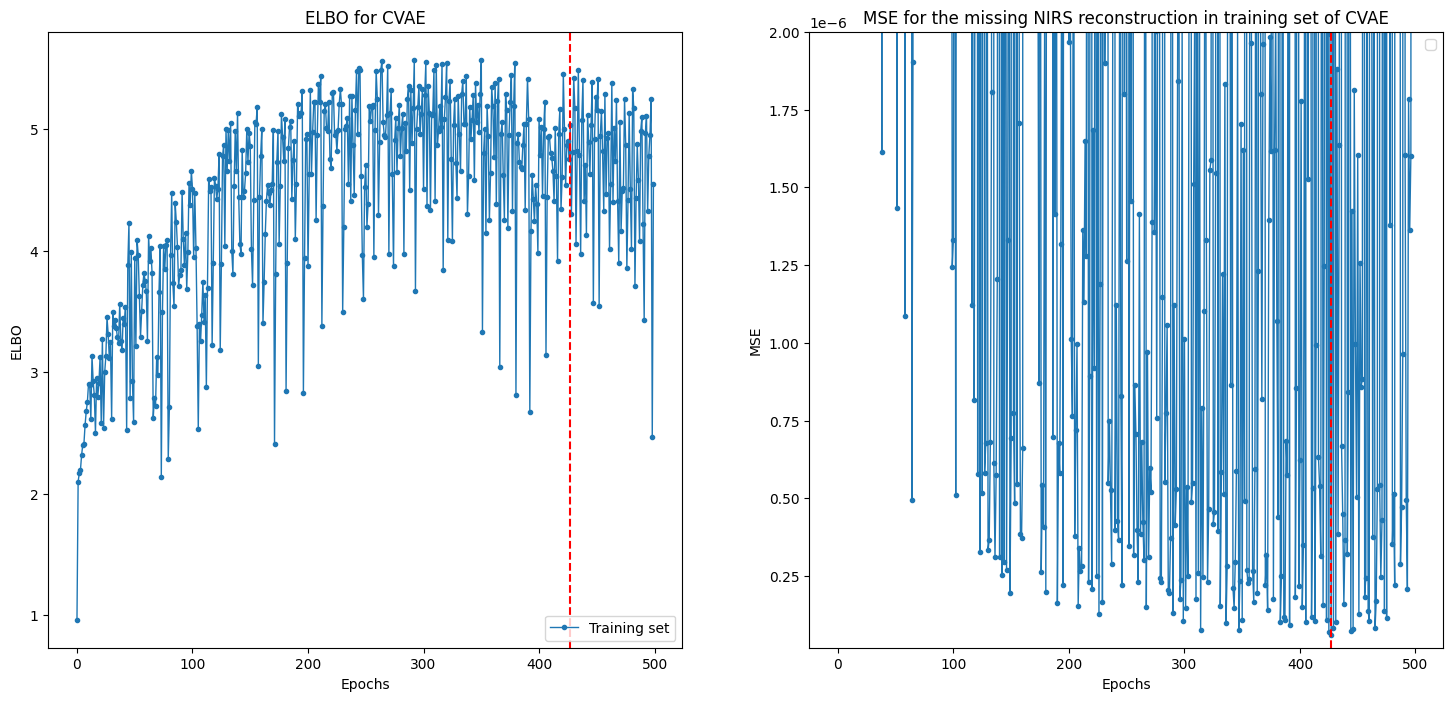

In [ ]:
# PLot training ELBO curve and MSE loss in prediction missing NIRS
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
ax1.plot(train_loss, label='Training set', marker='o', linestyle='solid', linewidth=1, markersize=3)
#ax1.plot(valid_loss, label='Validation set', marker='o', linestyle='solid', linewidth=1, markersize=3)
ax1.axvline(x = best_epoch, color='r', linestyle = '--')
ax1.set_title('ELBO for CVAE')
ax1.legend(loc='lower right')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('ELBO')

ax2.plot(train_mse, marker='o', linestyle='solid',linewidth=1, markersize=3)
#ax2.plot(valid_mse, label='Validation set', marker='o', linestyle='solid',linewidth=1, markersize=3)
ax2.axvline(x = best_epoch, color='r', linestyle = '--')
ax2.set_ylim(2e-8, 2e-6)
ax2.set_title("MSE for the missing NIRS reconstruction in training set of CVAE")
ax2.legend(loc='upper right')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

In [ ]:
# Training DVAE
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
train_loss, train_loss_dict, train_mse, best_epoch = dvae_trainer.train(nb_epochs=500,device=device,print_rate=100,model_save_path='saved_models/dvae_deri_20.pth')

Epoch [1/500]:
Reconstruction:
Train: ELBO: -1.6927, Reconstruction term 1: -0.8286, Reconstruction term 2: -0.8285, KLD term 1: 0.1777, KLD term 2: 0.1778.
Predict missing NIRS:
Train set: MSE: 0.0096032
min MSE: 0.009603202119107087.
Epoch [100/500]:
Reconstruction:
Train: ELBO: 10.2364, Reconstruction term 1: 5.2034, Reconstruction term 2: 5.2034, KLD term 1: 0.8517, KLD term 2: 0.8517.
Predict missing NIRS:
Train set: MSE: 0.0000027
min MSE: 7.036223469485022e-07.
Epoch [200/500]:
Reconstruction:
Train: ELBO: 10.1132, Reconstruction term 1: 5.1121, Reconstruction term 2: 5.1138, KLD term 1: 0.5636, KLD term 2: 0.5633.
Predict missing NIRS:
Train set: MSE: 0.0000015
min MSE: 1.6522918105338888e-07.
Epoch [300/500]:
Reconstruction:
Train: ELBO: 10.1828, Reconstruction term 1: 5.1431, Reconstruction term 2: 5.1439, KLD term 1: 0.5209, KLD term 2: 0.5214.
Predict missing NIRS:
Train set: MSE: 0.0000003
min MSE: 1.0612496475942119e-07.
Epoch [400/500]:
Reconstruction:
Train: ELBO: 11.68

Text(0, 0.5, 'MSE')

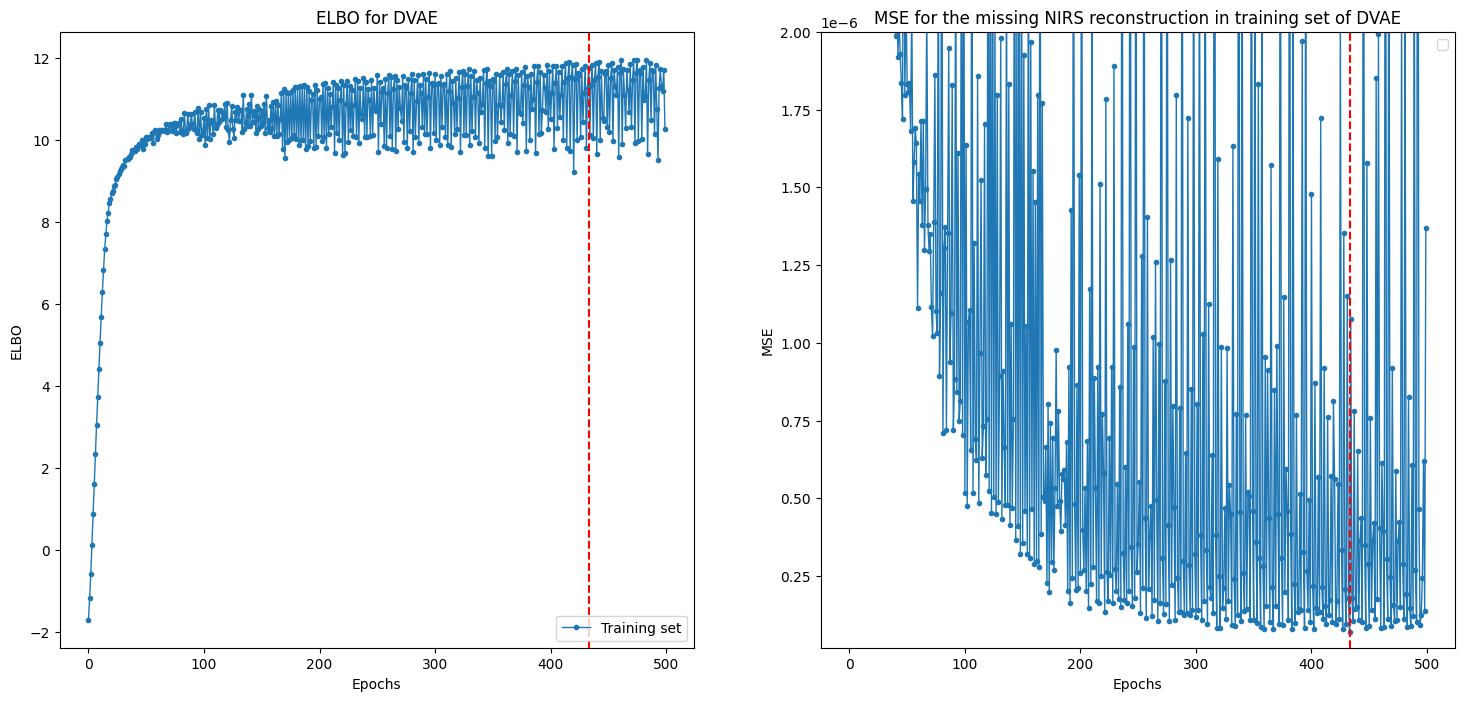

In [ ]:
# PLot training ELBO curve and MSE loss in prediction missing NIRS
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
ax1.plot(train_loss, label='Training set', marker='o', linestyle='solid', linewidth=1, markersize=3)
#ax1.plot(valid_loss, label='Validation set', marker='o', linestyle='solid', linewidth=1, markersize=3)
ax1.axvline(x = best_epoch, color='r', linestyle = '--')
ax1.set_title('ELBO for DVAE')
ax1.legend(loc='lower right')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('ELBO')

ax2.plot(train_mse, marker='o', linestyle='solid',linewidth=1, markersize=3)
#ax2.plot(valid_mse, label='Validation set', marker='o', linestyle='solid',linewidth=1, markersize=3)
ax2.axvline(x = best_epoch, color='r', linestyle = '--')
ax2.set_ylim(2e-8, 2e-6)
ax2.set_title("MSE for the missing NIRS reconstruction in training set of DVAE")
ax2.legend(loc='upper right')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

In [ ]:
# Training MLVAE
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
train_loss, train_loss_dict, train_mse, best_epoch = mlvae_trainer.train(nb_epochs=300,device=device,print_rate=100,model_save_path='saved_models/mlvae_deri_20.pth')

Epoch [1/300]:
Reconstruction:
Train: ELBO: -0.7132, Reconstruction term: -0.6995, KLD_v term: 0.0875, KLD_e term: 0.0497.
Predict missing NIRS:
Train set: MSE: 0.0073899
min MSE: 0.007389918504209314.
Epoch [100/300]:
Reconstruction:
Train: ELBO: 5.6060, Reconstruction term: 5.6789, KLD_v term: 0.7250, KLD_e term: 0.0036.
Predict missing NIRS:
Train set: MSE: 0.0000005
min MSE: 4.883629609694035e-07.
Epoch [200/300]:
Reconstruction:
Train: ELBO: 5.7490, Reconstruction term: 5.7746, KLD_v term: 0.2555, KLD_e term: 0.0014.
Predict missing NIRS:
Train set: MSE: 0.0000003
min MSE: 2.040248110252729e-07.
Epoch [300/300]:
Reconstruction:
Train: ELBO: 5.9505, Reconstruction term: 5.9673, KLD_v term: 0.1668, KLD_e term: 0.0009.
Predict missing NIRS:
Train set: MSE: 0.0000001
min MSE: 1.116599856198007e-07.


Text(0, 0.5, 'MSE')

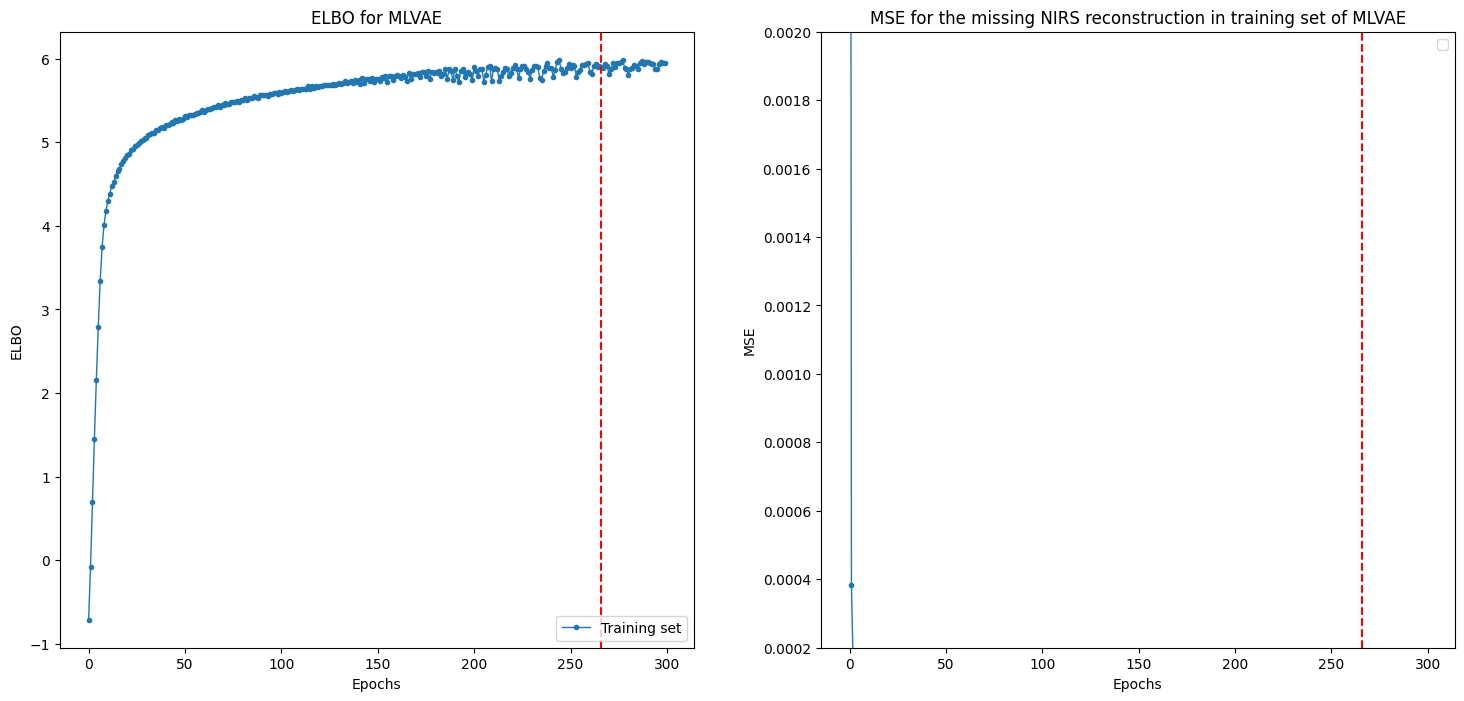

In [ ]:
# PLot training ELBO curve and MSE loss in prediction missing NIRS
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))
ax1.plot(train_loss, label='Training set', marker='o', linestyle='solid', linewidth=1, markersize=3)
#ax1.plot(valid_loss, label='Validation set', marker='o', linestyle='solid', linewidth=1, markersize=3)
ax1.axvline(x = best_epoch, color='r', linestyle = '--')
ax1.set_title('ELBO for MLVAE')
ax1.legend(loc='lower right')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('ELBO')

ax2.plot(train_mse, marker='o', linestyle='solid',linewidth=1, markersize=3)
#ax2.plot(valid_mse, label='Validation set', marker='o', linestyle='solid',linewidth=1, markersize=3)
ax2.axvline(x = best_epoch, color='r', linestyle = '--')
ax2.set_ylim(2e-4, 2e-3)
ax2.set_title("MSE for the missing NIRS reconstruction in training set of MLVAE")
ax2.legend(loc='upper right')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

**Load trained models**

In [16]:
# Load saved model
import os
state_dict = torch.load(os.path.join("saved_models", f"cvae_deri_20.pth"),
                        weights_only=True, map_location=device)
cvae.load_state_dict(state_dict)

state_dict = torch.load(os.path.join("saved_models", f"dvae_deri_20.pth"),
                        weights_only=True, map_location=device)
dvae.load_state_dict(state_dict)

state_dict = torch.load(os.path.join("saved_models", f"mlvae_deri_20.pth"),
                        weights_only=True, map_location=device)
mlvae.load_state_dict(state_dict)

<All keys matched successfully>

**Reconstruction results**

In [18]:
# Reconstruct missing NIRS
cvae_recon = reconstruct_all_cvae(cvae, cvae_trainer.train_loader, train_miss_20, device)
dvae_recon = reconstruct_all_dvae(dvae, train_miss_20, device)
mlvae_recon = reconstruct_all_mlvae(mlvae, train_miss_20, device)

In [19]:
# Compute MSE for training set
print(f'MSE baseline prediction for training set: {mse_base_train}')

mse_cvae, mse_df_cvae = mse_miss_recon(cvae_recon, cvae_trainer.train_gt)
print('CVAE MSE for training set: ',mse_cvae)

mse_dvae, mse_df_dvae = mse_miss_recon(dvae_recon, dvae_trainer.train_gt)
print('DVAE MSE for training set: ',mse_dvae)

mse_mlvae, mse_df_mlvae = mse_miss_recon(mlvae_recon, mlvae_trainer.train_gt)
print('MLVAE MSE for training set: ',mse_mlvae)

MSE baseline prediction for training set: 7.366137583766763e-08
No NIRS groundtruth available for the Geno76 in the environment Ragt_2022
No NIRS groundtruth available for the Geno84 in the environment Ragt_2021
CVAE MSE for training set:  6.052435386533887e-08
No NIRS groundtruth available for the Geno76 in the environment Ragt_2022
No NIRS groundtruth available for the Geno84 in the environment Ragt_2021
DVAE MSE for training set:  7.11952068214434e-08
No NIRS groundtruth available for the Geno76 in the environment Ragt_2022
No NIRS groundtruth available for the Geno84 in the environment Ragt_2021
MLVAE MSE for training set:  1.1165998561980071e-07


In [20]:
# MSE for each environment with baseline prediction
mse_env_base_train = mse_base_train_df.groupby('Environnement')['MSE'].mean()

# MSE for each environment
mse_env_cvae = mse_df_cvae.groupby('Environnement')['MSE'].mean()
mse_env_dvae = mse_df_dvae.groupby('Environnement')['MSE'].mean()
mse_env_mlvae = mse_df_mlvae.groupby('Environnement')['MSE'].mean()

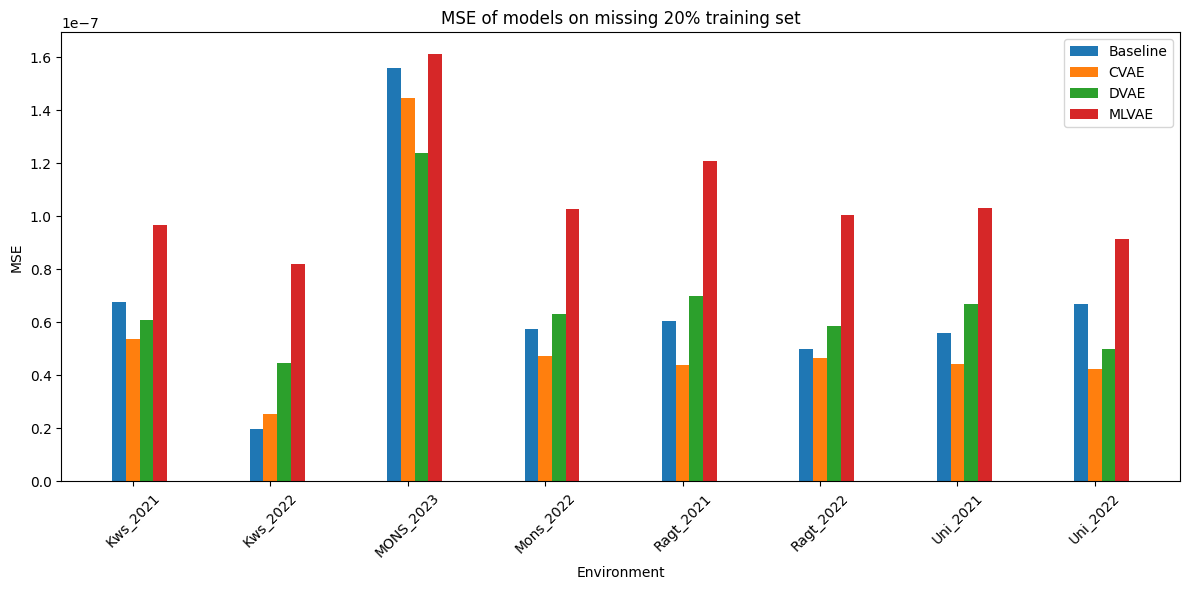

In [21]:
# Combine into a single DataFrame
df = pd.DataFrame({
    'Baseline': mse_env_base_train,
    'CVAE': mse_env_cvae,
    'DVAE': mse_env_dvae,
    'MLVAE': mse_env_mlvae
})

# Define the positions and width for the bars
positions = np.arange(len(df))
bar_width = 0.1

# Create the bar plots
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(positions - bar_width, df['Baseline'], bar_width, label='Baseline')
bars2 = ax.bar(positions, df['CVAE'], bar_width, label='CVAE')
bars1 = ax.bar(positions + bar_width, df['DVAE'], bar_width, label='DVAE')
bars2 = ax.bar(positions + 2*bar_width, df['MLVAE'], bar_width, label='MLVAE')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Environment')
ax.set_ylabel('MSE')
ax.set_title('MSE of models on missing 20% training set')
ax.set_xticks(positions)
ax.set_xticklabels(df.index, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [22]:
# Compute MSE for test set
print(f'MSE baseline prediction for test set: {mse_base_test}')

mse_dvae, mse_df_dvae = dvae_trainer.test(device)
print('DVAE MSE for test set: ',mse_dvae)

mse_mlvae, mse_df_mlvae = mlvae_trainer.test(device)
print('MLVAE MSE for test set: ',mse_mlvae)

MSE baseline prediction for test set: 5.606168855710659e-08
No NIRS groundtruth available for the Geno187 in the environment Ragt_2022
No NIRS groundtruth available for the Geno265 in the environment Ragt_2022
DVAE MSE for test set:  7.12479139409429e-08
No NIRS groundtruth available for the Geno187 in the environment Ragt_2022
No NIRS groundtruth available for the Geno265 in the environment Ragt_2022
MLVAE MSE for test set:  1.1194494489772198e-07


In [23]:
# MSE for each environment with baseline prediction
mse_env_base_test = mse_base_test_df.groupby('Environnement')['MSE'].mean()

# MSE for each environment
mse_env_dvae = mse_df_dvae.groupby('Environnement')['MSE'].mean()
mse_env_mlvae = mse_df_mlvae.groupby('Environnement')['MSE'].mean()

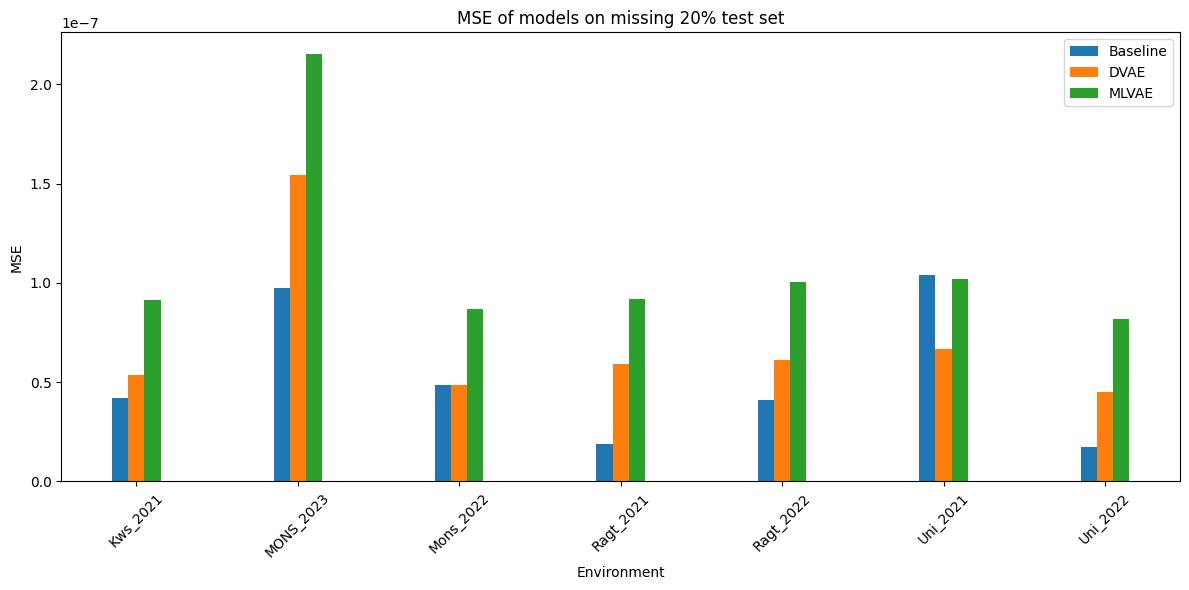

In [24]:
# Combine into a single DataFrame
df = pd.DataFrame({
    'Baseline': mse_env_base_test,
    'DVAE': mse_env_dvae,
    'MLVAE': mse_env_mlvae
})

# Define the positions and width for the bars
positions = np.arange(len(df))
bar_width = 0.1

# Create the bar plots
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(positions - bar_width, df['Baseline'], bar_width, label='Baseline')
bars1 = ax.bar(positions , df['DVAE'], bar_width, label='DVAE')
bars2 = ax.bar(positions + bar_width, df['MLVAE'], bar_width, label='MLVAE')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Environment')
ax.set_ylabel('MSE')
ax.set_title('MSE of models on missing 20% test set')
ax.set_xticks(positions)
ax.set_xticklabels(df.index, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## 4. Latent space

**Latent space visualisation**

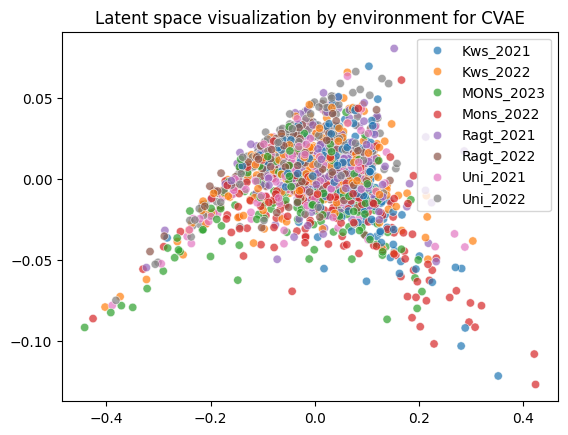

In [27]:
z_cvae, geno, env = latent_cvae(cvae, cvae_trainer.train_loader.dataset, device)
z_cvae_reduce = dimension_reduce(z_cvae, type='pca')
plt.figure()
sns.scatterplot(x = z_cvae_reduce[:,0], y = z_cvae_reduce[:,1], hue = env, alpha=0.7)
#plt.xlim(z_cvae_reduce[:,0].min(), z_cvae_reduce[:,1].max())
#plt.ylim(z_cvae_reduce[:,0].min(), z_cvae_reduce[:,1].max())
plt.title('Latent space visualization by environment for CVAE')

plt.show()

In [28]:
random_geno = np.array(['Geno212', 'Geno1', 'Geno158', 'Geno50', 'Geno86'])

Text(0.5, 1.0, 'Latent space visualization by 5 random varieties for CVAE')

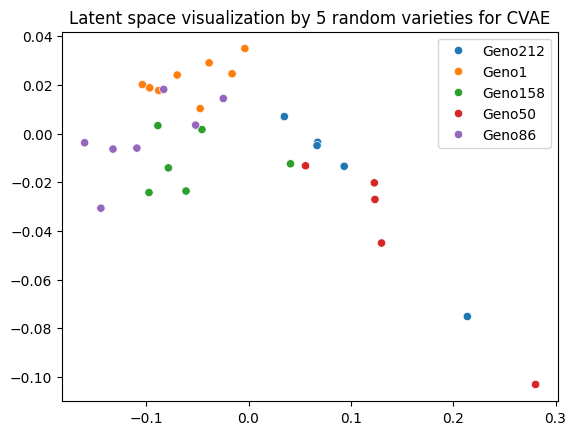

In [29]:
all_indices = []
for i in random_geno:
    indices = np.where(geno == i)[0]
    all_indices = np.concatenate((all_indices, indices))
all_indices = all_indices.astype(int)
z_geno = z_cvae_reduce[all_indices]
geno_list = geno[all_indices]
plt.figure()
sns.scatterplot(x = z_geno[:,0], y = z_geno[:,1], hue = geno_list)
plt.title('Latent space visualization by 5 random varieties for CVAE')

Text(0.5, 1.0, 'Latent space visualization by environment for DVAE')

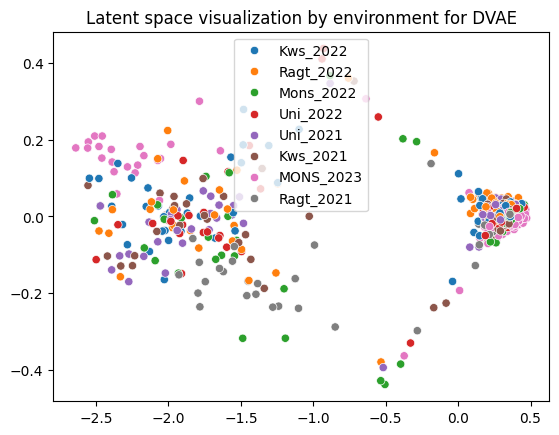

In [30]:
z_dvae, geno, env = latent_dvae(dvae, dvae_trainer.train_loader.dataset, device)
z_dvae_reduce = dimension_reduce(z_dvae, type='pca')
plt.figure()
sns.scatterplot(x = z_dvae_reduce[:,0], y = z_dvae_reduce[:,1], hue = env)
plt.title('Latent space visualization by environment for DVAE')

Text(0.5, 1.0, 'Latent space visualization by varieties for DVAE')

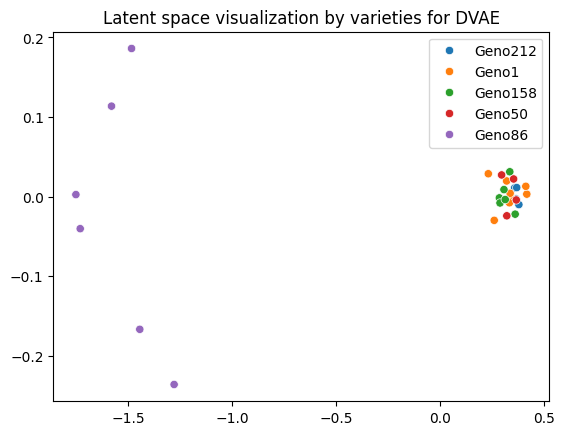

In [31]:
all_indices = []
for i in random_geno:
    indices = np.where(geno == i)[0]
    all_indices = np.concatenate((all_indices, indices))
all_indices = all_indices.astype(int)
z_geno = z_dvae_reduce[all_indices]
geno_list = geno[all_indices]
plt.figure()
sns.scatterplot(x = z_geno[:,0], y = z_geno[:,1], hue = geno_list)
plt.title('Latent space visualization by varieties for DVAE')

Text(0.5, 1.0, 'Latent space visualization by environment for MLVAE')

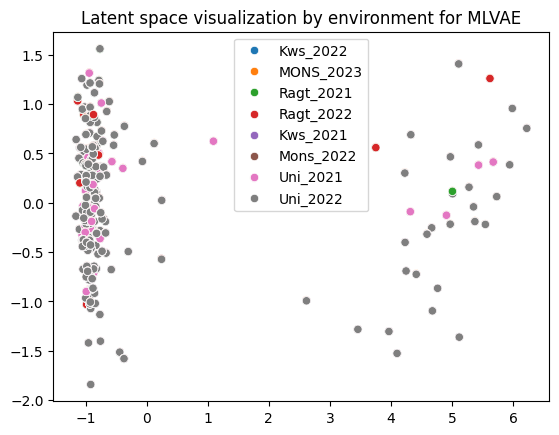

In [32]:
z_mlvae, geno, env = latent_mlvae(mlvae, mlvae_trainer.train_loader.dataset, device)
z_mlvae_reduce = dimension_reduce(z_mlvae, type='pca')
plt.figure()
sns.scatterplot(x = z_mlvae_reduce[:,0], y = z_mlvae_reduce[:,1], hue = env)
plt.title('Latent space visualization by environment for MLVAE')

Text(0.5, 1.0, 'Latent space visualization by varieties for MLVAE')

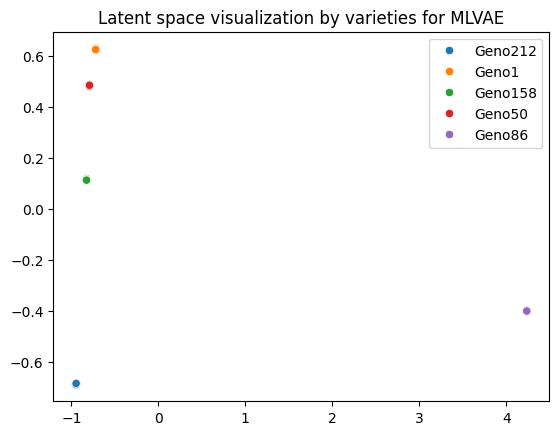

In [33]:
all_indices = []
for i in random_geno:
    indices = np.where(np.array(geno) == i)[0]
    all_indices = np.concatenate((all_indices, indices))
all_indices = all_indices.astype(int)
z_geno = z_mlvae_reduce[all_indices]
geno_list = np.array(geno)[all_indices]
plt.figure()
sns.scatterplot(x = z_geno[:,0], y = z_geno[:,1], hue = geno_list)
plt.title('Latent space visualization by varieties for MLVAE')